In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
import torch
from torch import cuda
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn.utils.spectral_norm as sn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import cv2
import math
from tqdm import tqdm
from tqdm.std import trange
from torch.utils.data import dataloader
from pixelshuffle1d import PixelShuffle1D, PixelUnshuffle1D

/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate data

$-\bigtriangledown\cdot  \left ( exp(\kappa ) \bigtriangledown u\left ( \textbf{x} \right )\right )=f\left ( \textbf{x} \right )$ 

$x\subseteq \left [ 0,1 \right ], y\subseteq \left [ 0,1 \right ]$ 

$f(x) = -(8π^2) * sin(2aπ(x+c)) * sin(2bπ(y+d))$

$a,b \in [0,2]; c,d \in [-2\pi,2\pi]$

$u(0,y)=u(1,y)=u(x,0)=u(x,1)=0$

### Finite-difference

In [3]:
def generate_data(N,type):
    h=1/N
    x=np.arange(0,1.0001,h)
    y=np.arange(0,1.0001,h)
    
    w=np.zeros((N+1,N+1))

    for j in range (0,N):
        w[0,j]=0 #Lower Boundary
        w[N,j]=0 #Upper Boundary
    
    N2=(N-1)*(N-1)
    A=np.zeros((N2,N2))
    ## Diagonal            
    for i in range (0,N-1):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j]=-4

    # LOWER DIAGONAL        
    for i in range (1,N-1):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j-1]=1   
    # UPPPER DIAGONAL        
    for i in range (0,N-2):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j+1]=1   

    # LOWER IDENTITY MATRIX
    for i in range (0,N-1):
        for j in range (1,N-1):           
            A[i+(N-1)*j,i+(N-1)*(j-1)]=1        
        
        
    # UPPER IDENTITY MATRIX
    for i in range (0,N-1):
        for j in range (0,N-2):           
            A[i+(N-1)*j,i+(N-1)*(j+1)]=1
    Ainv=np.linalg.inv(A) 
    
    r=np.zeros(N2)
    
    a = np.random.uniform(0,2)
    b = np.random.uniform(0,2)
    c = np.random.uniform(-2*np.pi,2*np.pi)
    d = np.random.uniform(-2*np.pi,2*np.pi)

    # vector r      
    for i in range (0,N-1):
        for j in range (0,N-1):
            if type == "mean":      
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*np.pi*x[i+1]) * np.sin(2*np.pi*y[j+1])*h**2
            elif type == "test":
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*1.2*np.pi*(x[i+1]-np.pi)) * np.sin(2*np.pi*(y[j+1]+np.pi))*h**2
            else:
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*np.pi*(x[i+1]+c)) * np.sin(2*np.pi*(y[j+1]+d))*h**2
    
    C=np.dot(Ainv,r)
    w[1:N,1:N]=C.reshape((N-1,N-1))
    
    return w, r, A, x, y

In [3]:
def create_T(n):
    m = np.zeros((n,n))
    m[0,0] = 1
    m[1,0] = 1
    m[n-1,n-1] = 1
    m[n-2,n-1] = 1
    
    for i in range(1,n-1):
        m[i,i] = -4
        
    for i in range(1,n-2):
        m[i,i+1] = 1
        m[i+1,i] = 1
    
    return m

def create_rest(n):
    m = np.zeros((n,n))
    m[1:n-1,1:n-1] = np.eye(n-2)
    return m


def generate_data(N):
    A_total = np.zeros(((N+1)**2,(N+1)**2))

    A_total[0:N+1,0:N+1] = np.eye(N+1)
    A_total[(N+1)*(N):(N+1)*(N)+N+1,(N+1)*(N):(N+1)*(N)+N+1] = np.eye(N+1)

    for i in range(1,N):
        A_total[(N+1)*i:(N+1)*i+(N+1),(N+1)*i:(N+1)*i+(N+1)] = create_T((N+1))
        
    for i in range(0,N-1):
        A_total[(N+1)*(i+1):(N+1)*(i+1)+(N+1),(N+1)*i:(N+1)*i+(N+1)] = create_rest((N+1))
        
        A_total[(N+1)*(i+1):(N+1)*(i+1)+(N+1),(N+1)*(i+2):(N+1)*(i+2)+(N+1)] = create_rest((N+1))
        
    h=1/N
    x=np.arange(0,1.0001,h)
    y=np.arange(0,1.0001,h)
    N2=(N-1)*(N-1)
    r=np.zeros(N2)

    # vector r      
    for i in range (0,N-1):
        for j in range (0,N-1):
            r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*np.pi*x[i+1]) * np.sin(2*np.pi*y[j+1])*h**2
                
    r_total = np.zeros((N+1)**2)
    for i in range(N-1):
        r_total[(N+1)*(i+1)+1:(N+1)*(i+1)+N] = r[(N-1)*i:(N-1)*i+(N-1)]
        
    Ainv=np.linalg.inv(A_total) 
    w_low = np.dot(Ainv,r_total).reshape((N+1,N+1))
    
    return w_low, r_total, A_total, x, y

In [4]:
N_low = 19
N_high = 99
w_low, r_low, A_low, x_low, y_low = generate_data(N_low)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high)

### Plot

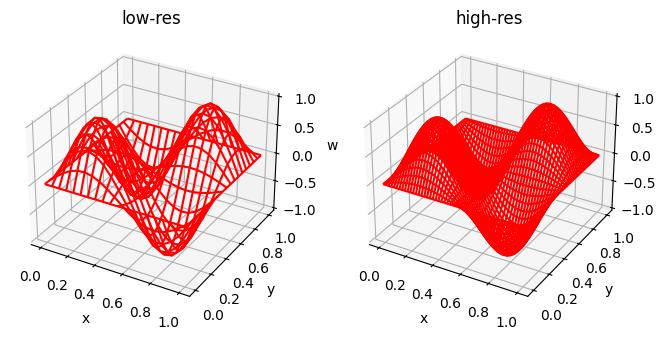

In [5]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, w_low,color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')
ax2 = fig.add_subplot(122, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

Text(0, 0.5, 'y')

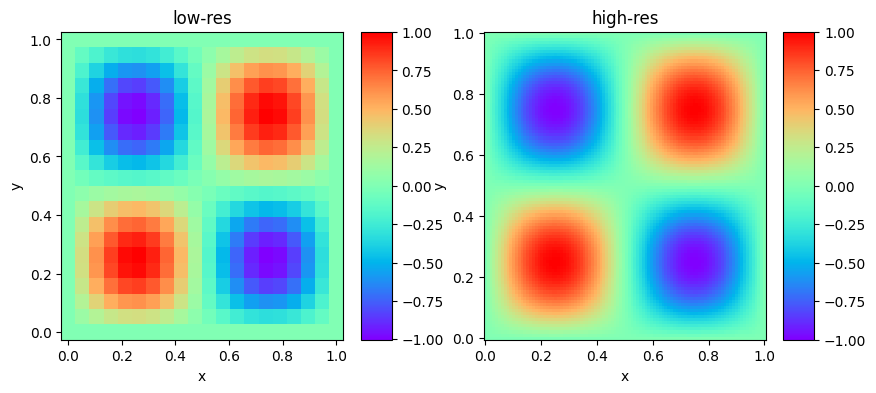

In [6]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low,y_low, w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.xlabel('x')
plt.ylabel('y')
plt.title('low-res')
plt.subplot(1,2,2)
plt.pcolormesh(x_high,y_high,w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('high-res')
plt.xlabel('x')
plt.ylabel('y')

## Calculate prior of $u^l$

In [14]:
def gaussian_kernal(x1,x2,y1,y2,l,sigma,N):
    m = (N-1)*(N-1)
    n = (N-1)*(N-1)
    dist_matrix = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            dist_matrix[i][j] = (y1[(i+1)%(N-1)]-y2[(i+1)%(N-1)])**2 + (x1[i//(N-1)+1]-x2[i//(N-1)+1])**2
            # dist_matrix[i][j] = (x1[(i+1)%(N-1)]-x2[(i+1)%(N-1)])**2 + (y1[i//(N-1)+1]-y2[i//(N-1)+1])**2
            #dist_matrix[i][j] = np.sum([x1[(i+1)%(N-1)],y1[i//(N-1)+1]]-[x2[(i+1)%(N-1)],y2[i//(N-1)+1]])**2
    
    return sigma ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)

# Define mean and covariance matrix of f
m = r_low
G = gaussian_kernal(x_low,x_low,y_low,y_low,0.1,0.3,N_low)

In [7]:
def gaussian_kernal_total(x1,x2,y1,y2,l,sigma,N):
    m = (N+1)*(N+1)
    n = (N+1)*(N+1)
    dist_matrix = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            dist_matrix[i][j] = (y1[(i)%(N+1)]-y2[(j)%(N+1)])**2 + (x1[i//(N+1)]-x2[j//(N+1)])**2
            # dist_matrix[i][j] = (x1[(i)%(N+1)]-x2[(i)%(N+1)])**2 + (y1[i//(N+1)+1]-y2[i//(N+1)+1])**2
            #dist_matrix[i][j] = np.sum([x1[(i)%(N+1)],y1[i//(N+1)+1]]-[x2[(i)%(N+1)],y2[i//(N+1)+1]])**2
    
    return sigma ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)

# Define mean and covariance matrix of f
m_total = r_low
G_total = gaussian_kernal_total(x_low,x_low,y_low,y_low,0.1,0.3,N_low)

In [23]:
# Mean and covariance matrix of u
mean_u = np.matmul(np.linalg.inv(A_low),m)
covariance_u = np.matmul(np.linalg.solve(A_low,G),np.linalg.inv(A_low).T)

In [8]:
mean_u_total = r_low
covariance_u_total = np.matmul(np.linalg.solve(A_low,G_total),np.linalg.inv(A_low).T)

In [18]:
mean_u_total = np.zeros((20,20))
mean_u_total[1:N_low,1:N_low] = mean_u.reshape(18,18)

In [19]:
covariance_u_total = np.zeros((400,400))
for i in range(18):
    for j in range(18):
        covariance_u_total[(i+1)*20+1:(i+1)*20+19,(j+1)*20+1:(j+1)*20+19] = covariance_u[18*i:18*i+18,18*j:18*j+18]

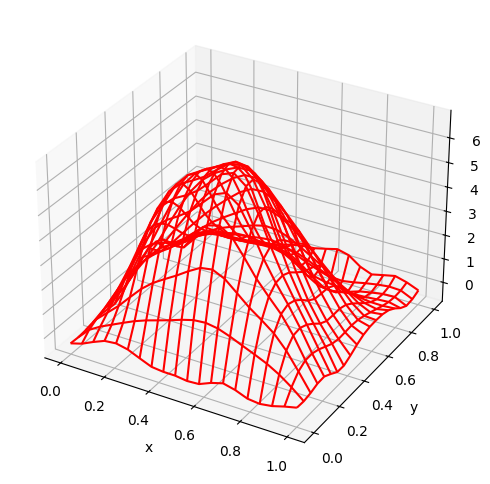

In [16]:
w_sample_total = np.random.multivariate_normal(mean_u_total.ravel(),covariance_u_total)
w_sample_total = w_sample_total.reshape(20,20)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_low, y_low)
ax.plot_wireframe(X, Y, w_sample_total,color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('w')
plt.show()

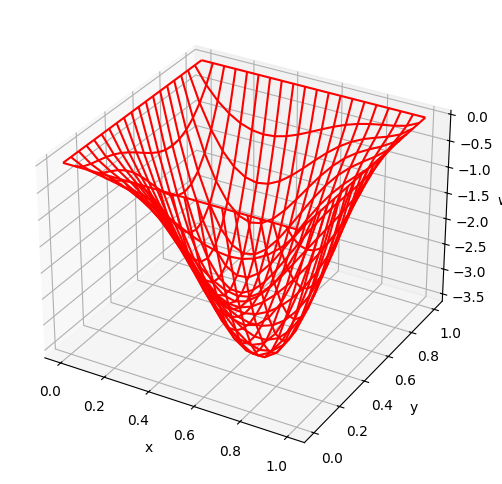

In [21]:
# Take one sample from the prior
C = np.random.multivariate_normal(mean_u.ravel(),covariance_u)
w_sample = np.copy(w_low)
w_sample[1:N_low,1:N_low]=C.reshape((N_low-1,N_low-1))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_low, y_low)
ax.plot_wireframe(X, Y, w_sample,color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('w')
plt.show()

Text(0, 0.5, 'y')

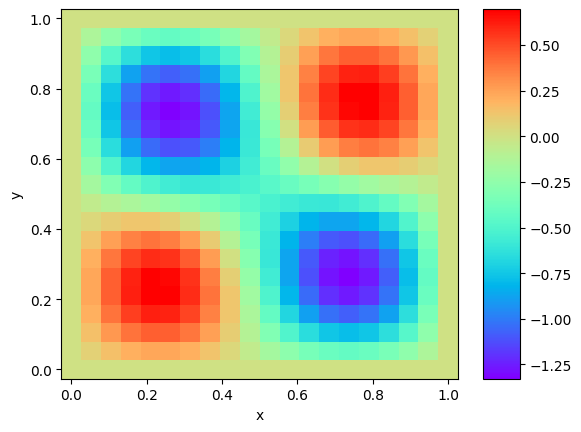

In [13]:
plt.pcolormesh(x_low,y_low, w_sample, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.xlabel('x')
plt.ylabel('y')

## Upscaling network

In [24]:
class UpScale(torch.nn.Module):
    def __init__(self):
        super(UpScale, self).__init__()
        self.layer1 = torch.nn.Conv2d(in_channels=1, out_channels=25, kernel_size=3, stride=1,padding=1)
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv2d(in_channels=25, out_channels=50, kernel_size=3, stride=1,padding=1)
        #self.layer3 = torch.nn.Conv1d(in_channels=6, out_channels=6, kernel_size=3, stride=1,padding=1)
        self.layer4 = torch.nn.Conv2d(in_channels=50, out_channels=25, kernel_size=3, stride=1,padding=1)
        self.PReLU = torch.nn.PReLU()
        self.shuffle = torch.nn.PixelShuffle(5)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.PReLU(x)
        #x = self.layer3(x)+x1
        x = self.layer4(x)
        x = self.shuffle(x)

        # log_probs = torch.nn.functional.log_softmax(x, dim=1)

        return x

model = UpScale()
input = torch.tensor(w_low.reshape(1, w_low.shape[0],-1))
input = input.to(torch.float32)
print(model(input).shape)

torch.Size([1, 100, 100])


## Dataloader

In [25]:
with h5py.File('/home/pz281@ad.eng.cam.ac.uk/mnt/PhD/Probabilistic_SR/data/high_res_GP.h5', 'r') as hf:
    data = hf['high_res_GP'][:]

In [26]:
trainset = torch.utils.data.DataLoader(dataset=data,batch_size=4,shuffle=False)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [28]:
data = torch.tensor(data.reshape(64,1,100,100))
data = data.to(torch.float32).to(device)

## Training

In [29]:
N_low = 19
N_high = 99
batch_size = 4

K = 60
s = 0.1

sigma = 0.3
epoch_num = 1000

In [30]:
G = UpScale()
G = G.to(device)
mse = nn.MSELoss(reduction='sum')
optG = torch.optim.Adam(G.parameters(), lr = 0.0001, weight_decay=0, betas=(0.5, 0.999))
r_scheduleG = torch.optim.lr_scheduler.ExponentialLR(optG, 0.998)

In [31]:
def sample_p_data():
    return data[torch.LongTensor(batch_size).random_(0, 64)].detach()

def sample_p_0(n = batch_size):
    prior = torch.randn(*[n, 1,20,20]).to(device)
    return prior

In [32]:
def ula_posterior(z, x, G):
    z = z.clone().detach().requires_grad_(True)
    chains_evolution = []
    for i in range(K):
        x_hat = G(z)
        g_log_likelihood = -1/(2*math.pow(sigma, 2))*mse(x_hat, x)
        grad_g = torch.autograd.grad(g_log_likelihood, z)[0]
        covariance = torch.tensor(covariance_u_total).to(device).to(torch.float32)
        grad_prior = -torch.matmul(torch.linalg.inv(covariance),(z.reshape(4,400,1)-torch.tensor(r_total.reshape(400,1)).to(device).to(torch.float32)))
        grad_prior = grad_prior.reshape(4,1,20,20)
        # grad_prior_middle = -torch.matmul(torch.linalg.inv(torch.tensor(covariance_u_total)),(z-torch.tensor(r_total)))
        z.data = z.data - 0.5*math.pow(s, 2)*(grad_g + grad_prior + 1/z.data) + s * torch.rand_like(z).data
        chains_evolution.append(z.cpu().data.numpy())      
    return z.detach(), chains_evolution

In [81]:
posterior_initial = sample_p_0()
z  = posterior_initial
z = z.clone().detach().requires_grad_(True)
x_hat = G(z)
g_log_likelihood = -1/(2*math.pow(sigma, 2))*mse(x_hat, x)
grad_g = torch.autograd.grad(g_log_likelihood, z)[0]

In [33]:
x = sample_p_data()
    
posterior_initial = sample_p_0()

posterior_final, posterior_chain = ula_posterior(posterior_initial, x, G)

In [36]:
posterior_chain[6]

array([[[[-inf,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]]],


       [[[-inf,  nan,  nan, ...,  nan,  nan,  inf],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]]],


       [[[ inf,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]]],


       [[[

In [86]:
for epoch in range(1, epoch_num+1):
    
    x = sample_p_data()
    
    posterior_initial = sample_p_0()

    posterior_final, posterior_chain = ula_posterior(posterior_initial, x, G)

    optG.zero_grad()
    x_hat = G(posterior_final.detach())
    loss_g = mse(x_hat, x)/batch_size
    loss_g.backward()
    optG.step()
    
    print("Epoch: {}".format(epoch),  "Loss: {}".format(loss_g.item()))


/tmp/ipykernel_1036702/2192980162.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grad_prior = -torch.matmul(torch.linalg.inv(torch.tensor(covariance)),(z.reshape(4,400,1)-torch.tensor(r_total.reshape(400,1)).to(device).to(torch.float32)))


Epoch: 1 Loss: nan
Epoch: 2 Loss: nan
Epoch: 3 Loss: nan
Epoch: 4 Loss: nan
Epoch: 5 Loss: nan
Epoch: 6 Loss: nan
Epoch: 7 Loss: nan
Epoch: 8 Loss: nan
Epoch: 9 Loss: nan
Epoch: 10 Loss: nan
Epoch: 11 Loss: nan


KeyboardInterrupt: 

In [22]:
x = sample_p_data()
    
posterior_initial = sample_p_0()
z = posterior_initial
z = z.clone().detach().requires_grad_(True)
x_hat = G(z)
g_log_likelihood = -1/(2*math.pow(sigma, 2))*mse(x_hat, x)
grad_g = torch.autograd.grad(g_log_likelihood, z)[0]

In [33]:
grad_g.shape

torch.Size([4, 1, 20, 20])

In [34]:
x_hat[:,:,1:99,1:99].shape

torch.Size([4, 1, 98, 98])

In [35]:
(z[:,:,1:19,1:19].reshape(4,324,)-torch.tensor(mean_u).to(device))

tensor([[ 0.3324, -0.3713, -1.1568,  ..., -1.4032,  0.2215,  0.3189],
        [-2.6005,  1.7802,  0.4302,  ...,  0.0715,  0.5585, -0.4908],
        [ 0.0283,  0.2793, -0.9236,  ..., -0.2269, -0.0201,  0.2261],
        [ 2.1840,  0.8995, -0.7530,  ...,  0.8335, -0.0693, -4.0768]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)

In [200]:
middle = torch.matmul(torch.linalg.inv(torch.tensor(covariance_u)).to(device),(z[:,:,1:19,1:19].reshape(4,324,)-torch.tensor(mean_u).to(device)).reshape(324,4))

In [184]:
grad_prior_middle = torch.matmul(torch.linalg.inv(torch.tensor(covariance_u)).to(device),(z[:,:,1:19,1:19].reshape(4,324,)-torch.tensor(mean_u).to(device)).reshape(324,4))
        

In [201]:
middle

tensor([[ 3.2546e+59,  6.6290e+59,  1.0656e+60,  7.4490e+59],
        [-1.7845e+59, -3.0378e+59, -4.3134e+59, -2.8868e+59],
        [-9.9766e+58, -6.6536e+58,  2.3564e+58,  4.5873e+58],
        ...,
        [-1.2371e+59, -1.9158e+59, -2.5030e+59, -1.6198e+59],
        [-5.1160e+56,  1.0416e+59,  2.6792e+59,  2.0992e+59],
        [-3.7309e+59, -4.3304e+59, -3.8393e+59, -1.9806e+59]], device='cuda:0',
       dtype=torch.float64, grad_fn=<MmBackward0>)

In [185]:
grad_prior_middle.shape

torch.Size([324, 4])

In [37]:
grad_prior = torch.ones((4,1,20,20)).to(device)
grad_prior_middle = torch.matmul(torch.linalg.inv(torch.tensor(covariance_u)).to(device),(z[:,:,1:19,1:19].reshape(4,324,)-torch.tensor(mean_u).to(device)).reshape(324,4))
grad_prior[:,:,1:19,1:19] = grad_prior_middle.reshape(4,1,18,18)

In [198]:
torch.linalg.inv(torch.tensor(covariance_u))

tensor([[-4.4200e+28,  6.4988e+30, -3.3251e+28,  ...,  9.3707e+14,
          5.1802e+14, -2.5424e+15],
        [-8.3498e+26, -3.5447e+30, -8.8334e+27,  ..., -1.5562e+14,
         -7.2855e+13,  1.5180e+14],
        [-4.1829e+28,  3.2733e+29, -1.3108e+28,  ...,  4.3517e+14,
          6.9471e+14, -9.0526e+14],
        ...,
        [ 4.0990e+26, -1.6277e+30,  1.3237e+28,  ..., -4.2409e+14,
         -3.5055e+14,  2.0242e+14],
        [-2.2582e+28,  1.4757e+30, -8.7367e+27,  ...,  7.2628e+14,
          8.1883e+14, -6.7232e+14],
        [-1.6988e+28, -3.8578e+30,  2.8489e+27,  ..., -1.0753e+14,
          2.2119e+14,  1.3307e+14]], dtype=torch.float64)

In [196]:
grad_prior

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., inf, inf,  ..., inf, inf, 1.],
          [1., inf, inf,  ..., inf, inf, 1.],
          ...,
          [1., inf, inf,  ..., inf, inf, 1.],
          [1., inf, inf,  ..., -inf, inf, 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., inf, inf,  ..., inf, inf, 1.],
          [1., inf, inf,  ..., -inf, -inf, 1.],
          ...,
          [1., -inf, -inf,  ..., inf, inf, 1.],
          [1., -inf, -inf,  ..., -inf, -inf, 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., -inf, -inf,  ..., -inf, -inf, 1.],
          [1., -inf, -inf,  ..., -inf, -inf, 1.],
          ...,
          [1., inf, inf,  ..., -inf, -inf, 1.],
          [1., -inf, -inf,  ..., inf, inf, 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., inf, inf,  ..., -inf, -inf, 1.],
          [1., inf, inf,  ..